##Test 1: dev modules to create necceary model utilities

In [ ]:
## dependencies
import os
import pandas as pd
import numpy as np
## import for data preparation
import torch
import pickle
from torch.utils.data import DataLoader, TensorDataset, Dataset

!pip install datasets==2.14.4
from datasets import load_dataset, Split
from datasets import Dataset



INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.0 MB/s eta 0:00:00


In [ ]:
## Basic setup
from google.colab import drive
drive.mount('/content/drive')
os.chdir('drive/MyDrive/oldAIboy/firstAIproject')

ValueError: mount failed

In [ ]:
## Basic setup
from google.colab import drive
drive.mount('/content/drive')
os.chdir('drive/MyDrive/oldAIboy/firstAIproject')

##Pull in the data
rawdata = pd.read_csv('IMDB Dataset.csv')
#rawdata = pd.read_csv('./drive/MyDrive/oldAIboy/firstAIproject/IMDB Dataset.csv')

Mounted at /content/drive


### Section 1 - use 'gensim' to create the token dictionary

In [ ]:
from gensim.utils import simple_preprocess
from gensim import corpora
sentlist = rawdata['review'].tolist()
tokens = [simple_preprocess(sent) for sent in sentlist] #use gensim.simple_preprocess to make tokens
dictionary = corpora.Dictionary(tokens)  #dictionary is a set of unique tokens, in the format of gansim dict
#dictionary.token2id

### Section 2, create tokenizer based on hugging face, and build the dataloaders

In [ ]:
%%time
from gensim import downloader
from transformers import BertTokenizer
glove = downloader.load('glove-wiki-gigaword-50')

##save embedding's vocab to a plain txt file, then utilize HF's tokenizer
to_add = ['[PAD]', '[UNK]']
words = glove.index_to_key
words = to_add + words
folder = os.getcwd()
## only need to run this once - create the local txt file
# with open(os.path.join(folder, 'vocab2.txt'), 'w') as f:
#         for word in words:
#             f.write(f'{word}\n')
## Create the tokenizer based on local txt file
glove_tokenizer = BertTokenizer('vocab2.txt')

[==================================================] 100.0% 66.0/66.0MB downloaded
CPU times: user 32.9 s, sys: 2.05 s, total: 35 s
Wall time: 44.2 s


In [ ]:
glove_tokenizer.ids_to_tokens[400]

'campaign'

In [ ]:
# !pip install datasets==2.14.4
# from datasets import load_dataset, Split
# from datasets import Dataset

# dataset = Dataset.from_pandas(rawdata)

# ##create data label
# def create_label(row):
#     sentiment_label = int(row['sentiment'] == 'positive')
#     return {'labels': sentiment_label}
# dataset = dataset.map(create_label)
########################################################################
##create the tokenizer, only need to run once
# ##shuffle and split
# shuffled_dataset = dataset.shuffle(seed=42)
# split_dataset = shuffled_dataset.train_test_split(test_size=0.2)
# train_dataset, test_dataset = split_dataset['train'], split_dataset['test']

# ## create the tokenizer
# train_ids = glove_tokenizer(train_dataset['review'], truncation=True, padding=True, max_length=99, add_special_tokens=False, return_tensors='pt')['input_ids']
# train_labels = torch.as_tensor(train_dataset['labels']).float().view(-1, 1)
# ##NOTE: temporarily put max length as 100, need to check how to update this
# test_ids = glove_tokenizer(test_dataset['review'], truncation=True, padding=True, max_length=99, add_special_tokens=False, return_tensors='pt')['input_ids']
# test_labels = torch.as_tensor(test_dataset['labels']).float().view(-1, 1)

##save data object, only need to run once
# saveObject = (train_ids, train_labels, test_ids, test_labels)
# pickle.dump(saveObject, open('tokenizer_train_test.pickle', 'wb'))



Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
with open("tokenizer_train_test.pickle", "rb") as f:
   train_ids, train_labels, test_ids, test_labels = pickle.load(f)

generator = torch.Generator()
train_tensor_dataset = TensorDataset(train_ids, train_labels)
train_loader = DataLoader(train_tensor_dataset, batch_size=32, shuffle=True, generator=generator)
test_tensor_dataset = TensorDataset(test_ids, test_labels)
test_loader = DataLoader(test_tensor_dataset, batch_size=32)

### section 3, create the embedding

In [ ]:
print(f'vocab length of the custom HF tokenizer: {len(glove_tokenizer.vocab)}')
print(f'vocab length of the original glove vocab: {len(glove.vectors)}')

vocab length of the custom HF tokenizer: 400002
vocab length of the original glove vocab: 400000


In [ ]:
special_embeddings = np.zeros((2, glove.vector_size))
extended_embeddings = np.concatenate([special_embeddings, glove.vectors], axis=0)

In [ ]:
print(f'vocab length of the custom HF tokenizer: {len(glove_tokenizer.vocab)}')
print(f'vocab length of the original glove vocab: {len(extended_embeddings)}')

vocab length of the custom HF tokenizer: 400002
vocab length of the original glove vocab: 400002


In [ ]:
alice_idx = glove_tokenizer.encode('are', add_special_tokens=False)
print(alice_idx)

[34]


In [ ]:
torch.allclose(torch.tensor(extended_embeddings[alice_idx]).view(50,),)

TypeError: allclose() missing 1 required positional arguments: "other"

##### little study code here - manipulte dype, compare tensors

In [ ]:
torch.allclose(emberesult, directglove)

True

In [ ]:
torch.equal(emberesult, directglove)

True

In [ ]:
emberesult=torch.tensor(extended_embeddings[alice_idx]).view(50, ).float()
torch.tensor(extended_embeddings[alice_idx]).view(50, ).float().dtype

torch.float32

In [ ]:
directglove=torch.tensor(glove['are'])
torch.tensor(glove['are']).dtype

torch.float32

##### resume codes here

### section 4. Set up embedding layer

In [ ]:
import torch
import torch.nn as nn
extended_embeddings = torch.as_tensor(extended_embeddings).float()
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)

In [ ]:
token_ids, labels =next(iter(train_loader))
token_ids

tensor([[   39, 14632,  1007,  ...,    37,  1556,    13],
        [  145,    43,    90,  ..., 19797, 30412,   276],
        [  199,     2, 43726,  ...,    28,   885,    17],
        ...,
        [   40,    96,  2592,  ...,     0,     0,     0],
        [66802, 13593,   967,  ...,     2,   181,     4],
        [   10,  6581,  1122,  ..., 24722,  1781,  6528]])

### section 5. Train the model:

In [ ]:
### one time code - download config.py file
# try:
#     import google.colab
#     import requests
#     url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
#     r = requests.get(url, allow_redirects=True)
#     open('config.py', 'wb').write(r.content)
# except ModuleNotFoundError:
#     pass

In [ ]:
from config import *
config_chapter11()
# This is needed to render the plots in this chapter
from plots.chapter11 import *

from seq2seq import *


Finished!


In [ ]:
class TransfClassifier(nn.Module):
    def __init__(self, embedding_layer, encoder, n_outputs):
        super().__init__()
        self.d_model = encoder.d_model
        self.n_outputs = n_outputs
        self.encoder = encoder
        self.mlp = nn.Linear(self.d_model, n_outputs)

        self.embed = embedding_layer
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.d_model))

    def preprocess(self, X):
        # N, L -> N, L, D
        src = self.embed(X)
        # Special classifier token
        # 1, 1, D -> N, 1, D
        cls_tokens = self.cls_token.expand(X.size(0), -1, -1)
        # Concatenates CLS tokens -> N, 1 + L, D
        src = torch.cat((cls_tokens, src), dim=1)
        return src

    def encode(self, source, source_mask=None):
        # Encoder generates "hidden states"
        states = self.encoder(source, source_mask)
        # Gets state from first token only: [CLS]
        cls_state = states[:, 0]  # N, 1, D
        return cls_state

    @staticmethod
    def source_mask(X):
        cls_mask = torch.ones(X.size(0), 1).type_as(X)
        pad_mask = torch.cat((cls_mask, X > 0), dim=1).bool()
        return pad_mask.unsqueeze(1)

    def forward(self, X):
        src = self.preprocess(X)
        # Featurizer
        cls_state = self.encode(src, self.source_mask(X))
        # Classifier
        out = self.mlp(cls_state) # N, 1, outputs
        return out

In [ ]:
torch.manual_seed(33)
# Loads the pretrained GloVe embeddings into an embedding layer
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)
# Creates a Transformer Encoder
layer = EncoderLayer(n_heads=2, d_model=torch_embeddings.embedding_dim, ff_units=128)
encoder = EncoderTransf(layer, n_layers=1)
# Uses both layers above to build our model
model = TransfClassifier(torch_embeddings, encoder, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
%%time
from stepbystep.v4 import StepByStep

sbs_transf = StepByStep(model, loss_fn, optimizer)
sbs_transf.set_loaders(train_loader, test_loader)
sbs_transf.train(10)

CPU times: user 1min 20s, sys: 1.32 s, total: 1min 21s
Wall time: 1min 28s


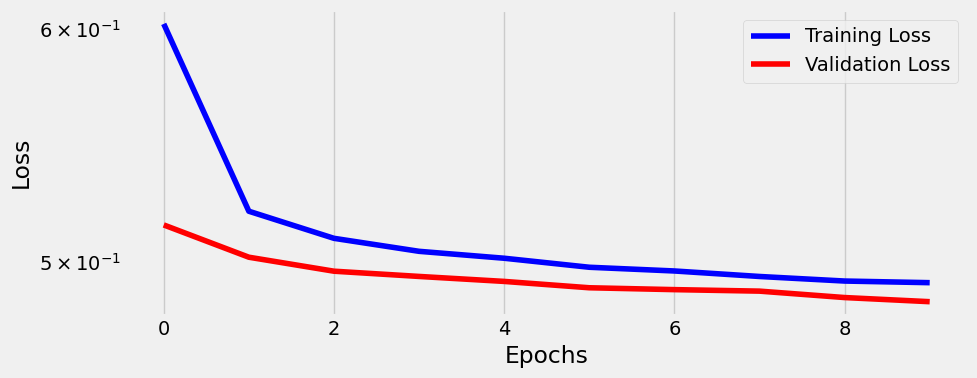

In [ ]:
fig = sbs_transf.plot_losses()

In [ ]:
%%time
torch.manual_seed(33)
# Loads the pretrained GloVe embeddings into an embedding layer
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)
# Creates a Transformer Encoder
layer = EncoderLayer(n_heads=8, d_model=torch_embeddings.embedding_dim, ff_units=128)
encoder = EncoderTransf(layer, n_layers=4)
# Uses both layers above to build our model
model = TransfClassifier(torch_embeddings, encoder, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

sbs_transf = StepByStep(model, loss_fn, optimizer)
sbs_transf.set_loaders(train_loader, test_loader)
sbs_transf.train(100)

RuntimeError: The size of tensor a (300) must match the size of tensor b (100) at non-singleton dimension 1

In [ ]:

from stepbystep.v4 import StepByStep



#### section 5.1 Train the train losses:

In [ ]:
print(sbs_transf.losses)
print(sbs_transf.val_losses)

[0.602448024058342, 0.520238685631752, 0.5093144853591919, 0.5041571205377579, 0.5014317439317704, 0.4979041632652283, 0.4964538392663002, 0.4943213804483414, 0.49255598328113553, 0.49192644770145416]
[0.5146806714252923, 0.501836569545368, 0.49636937416018767, 0.49433634551569294, 0.49241424121034033, 0.4899708595329199, 0.48925374605404304, 0.4886802562509482, 0.486229649367043, 0.48465425175980636]


## Test 2: Compile the script and train a larger model!
#### next step: create a dev notebook for sharing on github, a study notebook for detailed API learnings, the prod notebook can wait.

In [1]:
############################### Basic setup##################################
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('drive/MyDrive/oldAIboy/firstAIproject')

############################# dependencies###################################
import pandas as pd
import numpy as np
## import for data preparation
import torch
import pickle
from torch.utils.data import DataLoader, TensorDataset, Dataset

!pip install datasets==2.14.4
from datasets import load_dataset, Split
from datasets import Dataset

###section 1 build tokens
from gensim.utils import simple_preprocess
from gensim import corpora
### Section 2, create tokenizer based on hugging face, and build the dataloaders
from gensim import downloader
from transformers import BertTokenizer
!pip install datasets==2.14.4
from datasets import load_dataset, Split
from datasets import Dataset
### Section 4 & 5
import torch
import torch.nn as nn
from transformer_modules.transformer import *
from transformer_modules.stepbystep_v4 import StepByStep
# from seq2seq import *
# from stepbystep.v4 import StepByStep

Mounted at /content/drive
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.2 MB/s eta 0:00:00


#### Data Preparation

In [50]:
dataset

Dataset({
    features: ['review', 'sentiment', 'labels'],
    num_rows: 50000
})

In [51]:
dataset[0]

{'review': "One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is du

In [2]:
%%time
##Pull in the data
rawdata = pd.read_csv('IMDB Dataset.csv')
#rawdata = pd.read_csv('./drive/MyDrive/oldAIboy/firstAIproject/IMDB Dataset.csv')


############################# production codes ###################################
## set up hyper-parameters
max_len = 300
batch_size = 32
n_layers = 4
n_heads = 5
ff_units=128

###section 1 build token dictionary
sentlist = rawdata['review'].tolist()
tokens = [simple_preprocess(sent) for sent in sentlist] #use gensim.simple_preprocess to make tokens
dictionary = corpora.Dictionary(tokens)  #dictionary is a set of unique tokens, in the format of gansim dict
#dictionary.token2id

### Section 2, create tokenizer based on GLOVE by using huggingface, and build the dataloaders
glove = downloader.load('glove-wiki-gigaword-50')
##save embedding's vocab to a plain txt file, then utilize HF's tokenizer
to_add = ['[PAD]', '[UNK]']
words = glove.index_to_key
words = to_add + words
folder = os.getcwd()
# only need to run this once - create the local txt file
with open(os.path.join(folder, 'vocab2.txt'), 'w') as f:
        for word in words:
            f.write(f'{word}\n')

##* Create the tokenizer based on local txt file
glove_tokenizer = BertTokenizer('vocab2.txt')

##create data label
dataset = Dataset.from_pandas(rawdata)
def create_label(row):
    sentiment_label = int(row['sentiment'] == 'positive')
    return {'labels': sentiment_label}
dataset = dataset.map(create_label)

##create the tokenizer by utilizing Huggingface's API, only need to run once
# ##shuffle and split
# shuffled_dataset = dataset.shuffle(seed=42)
# split_dataset = shuffled_dataset.train_test_split(test_size=0.2)
# train_dataset, test_dataset = split_dataset['train'], split_dataset['test']
# # ## create the tokenizer
# train_ids = glove_tokenizer(train_dataset['review'], truncation=True, padding=True, max_length=max_len-1, add_special_tokens=False, return_tensors='pt')['input_ids']
# train_labels = torch.as_tensor(train_dataset['labels']).float().view(-1, 1)
# test_ids = glove_tokenizer(test_dataset['review'], truncation=True, padding=True, max_length=max_len-1, add_special_tokens=False, return_tensors='pt')['input_ids']
# test_labels = torch.as_tensor(test_dataset['labels']).float().view(-1, 1)
# ##save data object
# saveObject = (train_ids, train_labels, test_ids, test_labels)
# pickle.dump(saveObject, open('data_tokens_300seq.pickle', 'wb'))

with open("data_tokens_300seq.pickle", "rb") as f:
   train_ids, train_labels, test_ids, test_labels = pickle.load(f)

generator = torch.Generator()
train_tensor_dataset = TensorDataset(train_ids, train_labels)
train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True, generator=generator)
test_tensor_dataset = TensorDataset(test_ids, test_labels)
test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size)

## Section3: Build the extended embedding
special_embeddings = np.zeros((2, glove.vector_size))
extended_embeddings = np.concatenate([special_embeddings, glove.vectors], axis=0)

## Section 4: customize a transformer based classifier
class TransfClassifier(nn.Module):
    def __init__(self, embedding_layer, encoder, n_outputs):
        super().__init__()
        self.d_model = encoder.d_model
        self.n_outputs = n_outputs
        self.encoder = encoder
        self.mlp = nn.Linear(self.d_model, n_outputs)

        self.embed = embedding_layer
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.d_model))

    def preprocess(self, X):
        # N, L -> N, L, D
        src = self.embed(X)
        # Special classifier token
        # 1, 1, D -> N, 1, D
        cls_tokens = self.cls_token.expand(X.size(0), -1, -1)
        # Concatenates CLS tokens -> N, 1 + L, D
        src = torch.cat((cls_tokens, src), dim=1)
        return src

    def encode(self, source, source_mask=None):
        # Encoder generates "hidden states"
        states = self.encoder(source, source_mask)
        # Gets state from first token only: [CLS]
        cls_state = states[:, 0]  # N, 1, D
        return cls_state

    @staticmethod
    def source_mask(X):
        cls_mask = torch.ones(X.size(0), 1).type_as(X)
        pad_mask = torch.cat((cls_mask, X > 0), dim=1).bool()
        return pad_mask.unsqueeze(1)

    def forward(self, X):
        src = self.preprocess(X)
        # Featurizer
        cls_state = self.encode(src, self.source_mask(X))
        # Classifier
        out = self.mlp(cls_state) # N, 1, outputs
        return out

[==================================================] 100.0% 66.0/66.0MB downloaded


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

CPU times: user 50.2 s, sys: 2.94 s, total: 53.2 s
Wall time: 1min 3s


#### Initial model test



CPU times: user 1min 50s, sys: 832 ms, total: 1min 51s
Wall time: 1min 52s


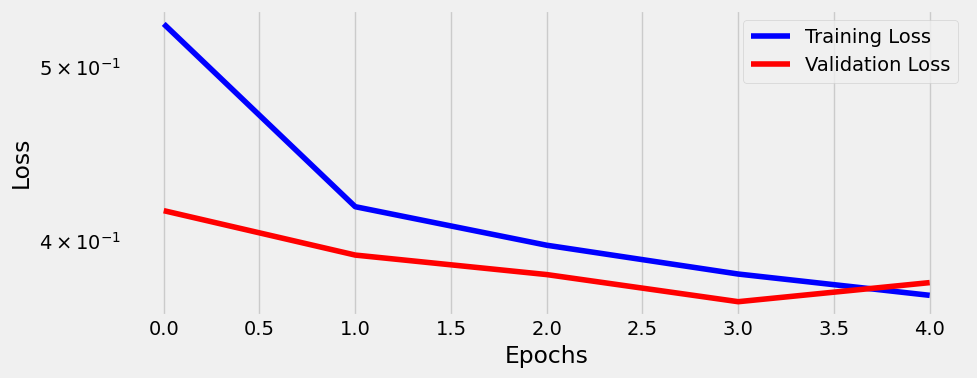

In [ ]:
%%time
torch.manual_seed(33)
# Loads the pretrained GloVe embeddings into an embedding layer
extended_embeddings = torch.as_tensor(extended_embeddings).float()
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)
# Creates a Transformer Encoder
layer = EncoderLayer(n_heads=n_heads, d_model=torch_embeddings.embedding_dim, ff_units=ff_units)
encoder = EncoderTransf(layer, n_layers=n_layers, max_len=max_len)

# Uses both layers above to build our model
model = TransfClassifier(torch_embeddings, encoder, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)



sbs_transf = StepByStep(model, loss_fn, optimizer)
sbs_transf.set_loaders(train_loader, test_loader)
sbs_transf.train(5)

fig = sbs_transf.plot_losses()

#### Initial model test - evaluation

In [ ]:
## implement the model inference

device = 'cuda' if torch.cuda.is_available() else 'cpu'

logits_tensor = torch.empty((0, logits.shape[1]), device=device)  # Create an empty tensor on the device

# Loop through the test data in batches of 100
for i in range(0, len(test_ids), 100):
    # Extract a batch of 100 data points
    batch = test_ids[i:i + 100].to(device)

    # Perform model inference
    with torch.no_grad():  # Disable gradient calculation during inference
        logits = sbs_transf.model(batch)

    # Append the logits to the list
    logits_tensor = torch.cat([logits_tensor, logits], dim=0)  # Concatenate logits to the tensor

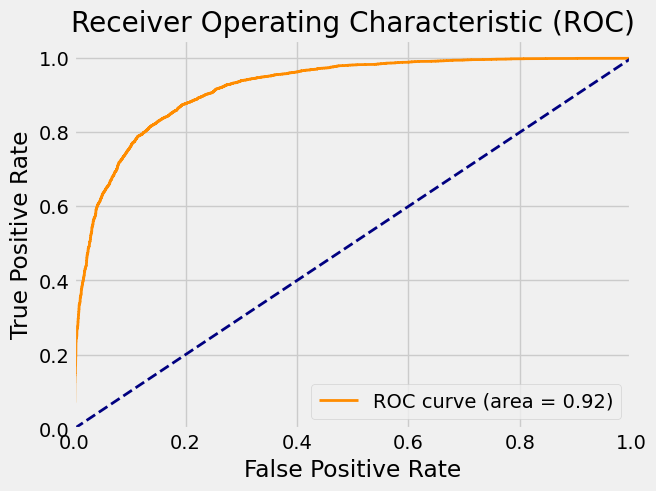

AUC Score: 0.9213718049095676
Accuracy Score: 0.83
Logged Loss: 0.3791142291582803


In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
import numpy as np
from sklearn.metrics import log_loss

# Assuming you have:
# - logits_tensor: a PyTorch tensor containing the inference logits
# - test_labels: a PyTorch tensor containing the true labels

# 1. Convert logits to probabilities
probabilities = torch.sigmoid(logits_tensor).cpu().detach().numpy()

# 2. Convert probabilities to binary predictions (0 or 1)
predictions = (probabilities >= 0.5).astype(int)

# 3. Calculate AUC score
auc_score = roc_auc_score(test_labels.cpu().detach().numpy(), probabilities)

# 4. Calculate accuracy score
accuracy = accuracy_score(test_labels.cpu().detach().numpy(), predictions)

# 5. Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_labels.cpu().detach().numpy(), probabilities)
roc_auc = auc(fpr, tpr)

# 6. Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 7. Calculate logged loss
# Convert test_labels to NumPy and ensure it's in the correct shape
test_labels_np = test_labels.cpu().detach().numpy()
# test_labels_np = test_labels_np.reshape(-1, 1)  # Reshape if necessary (e.g., if it's a 1D array)
# test_labels_np = test_labels_np.astype(int)  # Ensure data type is int

# Clip probabilities to avoid log(0) errors
probabilities_clipped = np.clip(probabilities, 1e-15, 1 - 1e-15)

logged_loss = log_loss(test_labels_np, probabilities_clipped)

# Print the results
print(f"AUC Score: {auc_score}")
print(f"Accuracy Score: {accuracy}")
print(f"Logged Loss: {logged_loss}")

#### Deep model test

CPU times: user 35min 52s, sys: 6.2 s, total: 35min 58s
Wall time: 35min 50s


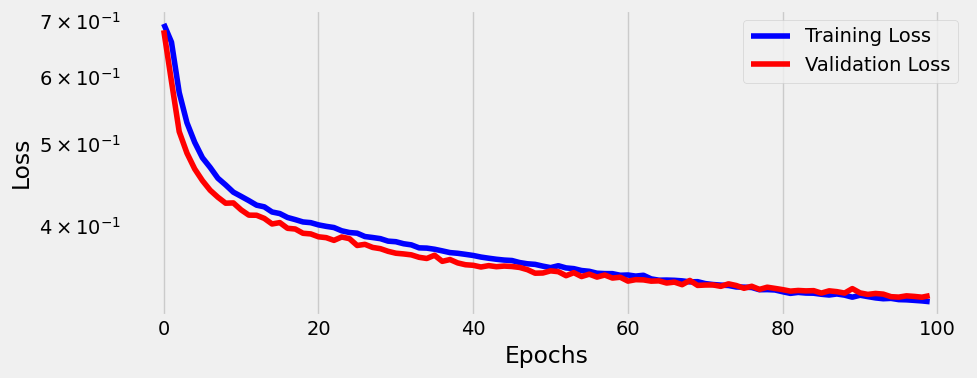

In [ ]:
%%time
n_heads = 5
torch.manual_seed(33)
# Loads the pretrained GloVe embeddings into an embedding layer
extended_embeddings = torch.as_tensor(extended_embeddings).float()
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)
# Creates a Transformer Encoder
layer = EncoderLayer(n_heads=n_heads, d_model=torch_embeddings.embedding_dim, ff_units=ff_units)
encoder = EncoderTransf(layer, n_layers=n_layers, max_len=max_len)

# Uses both layers above to build our model
model = TransfClassifier(torch_embeddings, encoder, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

sbs_transf = StepByStep(model, loss_fn, optimizer)
sbs_transf.set_loaders(train_loader, test_loader)
sbs_transf.train(100)

fig = sbs_transf.plot_losses()

#### Deep model test - evaluation

In [ ]:
## implement the model inference

device = 'cuda' if torch.cuda.is_available() else 'cpu'

logits_tensor = torch.empty((0, logits.shape[1]), device=device)  # Create an empty tensor on the device

# Loop through the test data in batches of 100
for i in range(0, len(test_ids), 100):
    # Extract a batch of 100 data points
    batch = test_ids[i:i + 100].to(device)

    # Perform model inference
    with torch.no_grad():  # Disable gradient calculation during inference
        logits = sbs_transf.model(batch)

    # Append the logits to the list
    logits_tensor = torch.cat([logits_tensor, logits], dim=0)  # Concatenate logits to the tensor

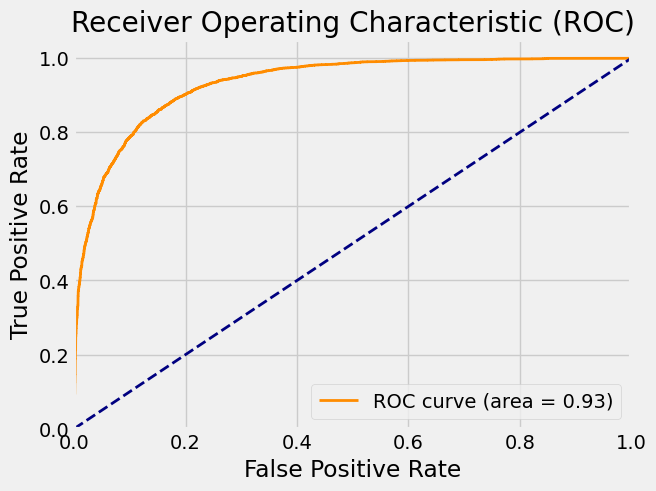

AUC Score: 0.9333365976096218
Accuracy Score: 0.8533
Logged Loss: 0.3313227037324152


In [ ]:
## Evaluate model performance
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, log_loss
import numpy as np

# Assuming you have:
# - logits_tensor: a PyTorch tensor containing the inference logits
# - test_labels: a PyTorch tensor containing the true labels

# 1. Convert logits to probabilities
probabilities = torch.sigmoid(logits_tensor).cpu().detach().numpy()

# 2. Convert probabilities to binary predictions (0 or 1)
predictions = (probabilities >= 0.5).astype(int)

# 3. Calculate AUC score
auc_score = roc_auc_score(test_labels.cpu().detach().numpy(), probabilities)

# 4. Calculate accuracy score
accuracy = accuracy_score(test_labels.cpu().detach().numpy(), predictions)

# 5. Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_labels.cpu().detach().numpy(), probabilities)
roc_auc = auc(fpr, tpr)

# 6. Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 7. Calculate logged loss
# Convert test_labels to NumPy and ensure it's in the correct shape
test_labels_np = test_labels.cpu().detach().numpy()
# test_labels_np = test_labels_np.reshape(-1, 1)  # Reshape if necessary (e.g., if it's a 1D array)
# test_labels_np = test_labels_np.astype(int)  # Ensure data type is int

# Clip probabilities to avoid log(0) errors
probabilities_clipped = np.clip(probabilities, 1e-15, 1 - 1e-15)

logged_loss = log_loss(test_labels_np, probabilities_clipped)

# Print the results
print(f"AUC Score: {auc_score}")
print(f"Accuracy Score: {accuracy}")
print(f"Logged Loss: {logged_loss}")

#### Save & Load model, implement inference

In [ ]:
# Save the model - Assuming you have:
# - model: your trained PyTorch model
# - PATH: the file path where you want to save the model (e.g., 'my_model.pth')

# 1. Save the model's state_dict
#torch.save(sbs_transf.model.state_dict(), 'deep_model_trained1219.pth')

In [3]:
# Load the model
# Assuming you have:
# - model: an instance of the same model class that you saved
 ## (need to run the model configuration again)
# - PATH: the file path where the model is saved

# 1. Load the saved state_dict
state_dict = torch.load('deep_model_trained1219.pth')

# 2. Load the state_dict into your model
torch.manual_seed(33)
# Loads the pretrained GloVe embeddings into an embedding layer
extended_embeddings = torch.as_tensor(extended_embeddings).float()
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)
# Creates a Transformer Encoder
layer = EncoderLayer(n_heads=n_heads, d_model=torch_embeddings.embedding_dim, ff_units=ff_units)
encoder = EncoderTransf(layer, n_layers=n_layers, max_len=max_len)
# Uses both layers above to build our model
model = TransfClassifier(torch_embeddings, encoder, n_outputs=1)

model.load_state_dict(state_dict)

# 3. Set the model to evaluation mode (if needed)
model.eval()

<ipython-input-3-2c14b64ee95c>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('deep_model_trained1219.pth')


TransfClassifier(
  (encoder): EncoderTransf(
    (pe): PositionalEncoding()
    (norm): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-3): 4 x EncoderLayer(
        (self_attn_heads): MultiHeadedAttention(
          (linear_query): Linear(in_features=50, out_features=50, bias=True)
          (linear_key): Linear(in_features=50, out_features=50, bias=True)
          (linear_value): Linear(in_features=50, out_features=50, bias=True)
          (linear_out): Linear(in_features=50, out_features=50, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ffn): Sequential(
          (0): Linear(in_features=50, out_features=128, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=128, out_features=50, bias=True)
        )
        (sublayers): ModuleList(
          (0-1): 2 x SubLayerWrapper(
            (norm): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
     

In [7]:
%%time
## implement the model inference
device = 'cuda' if torch.cuda.is_available() else 'cpu'

logits_tensor = torch.empty((0, 1), device=device)  # Create an empty tensor on the device

# Loop through the test data in batches of 100
for i in range(0, len(test_ids), 100):
    # Extract a batch of 100 data points
    batch = test_ids[i:i + 100].to(device)

    # Perform model inference
    model.to(device)
    with torch.no_grad():  # Disable gradient calculation during inference
        logits = model(batch)

    # Append the logits to the list
    logits_tensor = torch.cat([logits_tensor, logits], dim=0)  # Concatenate logits to the tensor

CPU times: user 2.22 s, sys: 90.8 ms, total: 2.31 s
Wall time: 2.64 s


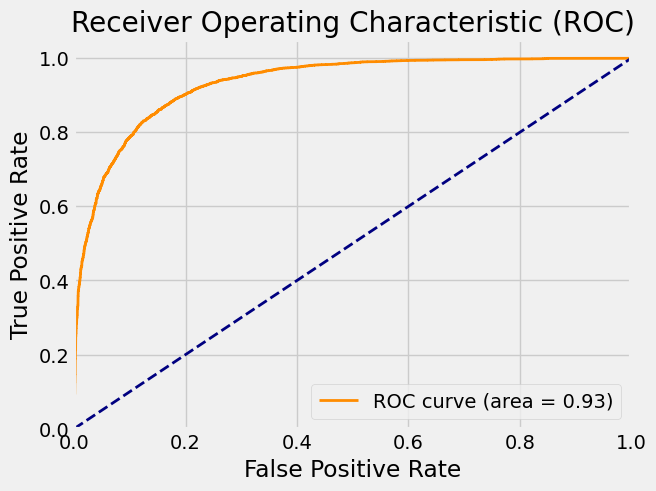

AUC Score: 0.9333365976096218
Accuracy Score: 0.8533
Logged Loss: 0.3313227037324152
CPU times: user 500 ms, sys: 252 ms, total: 751 ms
Wall time: 655 ms


In [8]:
%%time
## Evaluate model performance
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, log_loss
import numpy as np

# Assuming you have:
# - logits_tensor: a PyTorch tensor containing the inference logits
# - test_labels: a PyTorch tensor containing the true labels

# 1. Convert logits to probabilities
probabilities = torch.sigmoid(logits_tensor).cpu().detach().numpy()

# 2. Convert probabilities to binary predictions (0 or 1)
predictions = (probabilities >= 0.5).astype(int)

# 3. Calculate AUC score
auc_score = roc_auc_score(test_labels.cpu().detach().numpy(), probabilities)

# 4. Calculate accuracy score
accuracy = accuracy_score(test_labels.cpu().detach().numpy(), predictions)

# 5. Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_labels.cpu().detach().numpy(), probabilities)
roc_auc = auc(fpr, tpr)

# 6. Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 7. Calculate logged loss
# Convert test_labels to NumPy and ensure it's in the correct shape
test_labels_np = test_labels.cpu().detach().numpy()
# test_labels_np = test_labels_np.reshape(-1, 1)  # Reshape if necessary (e.g., if it's a 1D array)
# test_labels_np = test_labels_np.astype(int)  # Ensure data type is int

# Clip probabilities to avoid log(0) errors
probabilities_clipped = np.clip(probabilities, 1e-15, 1 - 1e-15)

logged_loss = log_loss(test_labels_np, probabilities_clipped)

# Print the results
print(f"AUC Score: {auc_score}")
print(f"Accuracy Score: {accuracy}")
print(f"Logged Loss: {logged_loss}")

#### Some random education - RUN inference on some random text // then study on the attention's focus


In [4]:
##randomly pick one reivew
dataset[3]

{'review': "Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.",
 'sentiment': 'negative',
 'labels': 0}

In [5]:
## tokenize it
tokens = glove_tokenizer(dataset['review'][3], truncation=True, padding=True, max_length=max_len-1, add_special_tokens=False, return_tensors='pt')['input_ids']
tokens

tensor([[  5205,     65,     59,   1536,      9,    215,    113,      9,    335,
           1608,     25,  10148,     26,   4200,     65,     59,   1536,      9,
          20376,      8,     28,  12878,   1163,     28,   1110,     34,    800,
             66,      2,     81,      4,  19797,  30412,    276,  12259,  19797,
          30412,    276,  12259,     39,   1007,     16,   6916,     75,      9,
           7320,   2834,      4,      4,      4,      7,   3711,      3,  10148,
           6040,      6,    401,  35767,      7,   1918,      2,  20376,      4,
          19797,  30412,    276,  12259,  19797,  30412,    276,  12259,   4864,
              3,     60,      5,     66,     63,     83,     59,   1767,    224,
              6,    161,      9,    321,     83,    392,   2101,     85,     49,
              9,   8967,     48,      9,   2694,    807,     21,      9,   2694,
              2,   1007,     16,  59342,      4,   1110,     34,  39332,   1163,
           4992,    119,    

In [6]:
# Perform model inference - logits
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
with torch.no_grad():  # Disable gradient calculation during inference
  logits = model(tokens.to(device))

print(logits)

## Turn logits to probability
torch.sigmoid(logits)

tensor([[-2.6593]], device='cuda:0')


tensor([[0.0654]], device='cuda:0')

In [7]:
model.encoder.layers

ModuleList(
  (0-3): 4 x EncoderLayer(
    (self_attn_heads): MultiHeadedAttention(
      (linear_query): Linear(in_features=50, out_features=50, bias=True)
      (linear_key): Linear(in_features=50, out_features=50, bias=True)
      (linear_value): Linear(in_features=50, out_features=50, bias=True)
      (linear_out): Linear(in_features=50, out_features=50, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (ffn): Sequential(
      (0): Linear(in_features=50, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=128, out_features=50, bias=True)
    )
    (sublayers): ModuleList(
      (0-1): 2 x SubLayerWrapper(
        (norm): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
  )
)

In [8]:
## fetch the attention score matrix
model.encoder.layers[0].self_attn_heads.alphas.shape

torch.Size([1, 5, 300, 300])

In [13]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [7]:
##fetch the attention score matrix from the 1st layer for the 1st token (special classify token)
attscore = model.encoder.layers[0].self_attn_heads.alphas[0,0,3]
attscore

# # Before accessing attention scores (alphas)
# alphas = model.encoder.layers[0].self_attn_heads.alphas.cpu()  # Move alphas to CPU

# # Now you can access alphas using CPU indexing
# attscore = alphas[0, 0, 0]

tensor([0.0031, 0.0084, 0.0068, 0.0051, 0.0034, 0.0055, 0.0043, 0.0041, 0.0057,
        0.0076, 0.0064, 0.0029, 0.0050, 0.0029, 0.0068, 0.0066, 0.0051, 0.0035,
        0.0058, 0.0033, 0.0038, 0.0073, 0.0054, 0.0026, 0.0070, 0.0041, 0.0069,
        0.0039, 0.0069, 0.0047, 0.0061, 0.0054, 0.0029, 0.0041, 0.0024, 0.0025,
        0.0030, 0.0042, 0.0025, 0.0027, 0.0068, 0.0073, 0.0060, 0.0066, 0.0070,
        0.0060, 0.0036, 0.0038, 0.0056, 0.0056, 0.0056, 0.0053, 0.0099, 0.0049,
        0.0053, 0.0041, 0.0048, 0.0064, 0.0074, 0.0051, 0.0053, 0.0044, 0.0033,
        0.0055, 0.0030, 0.0043, 0.0025, 0.0026, 0.0029, 0.0041, 0.0024, 0.0026,
        0.0077, 0.0048, 0.0066, 0.0036, 0.0071, 0.0082, 0.0083, 0.0053, 0.0054,
        0.0075, 0.0047, 0.0075, 0.0061, 0.0052, 0.0079, 0.0051, 0.0044, 0.0082,
        0.0044, 0.0064, 0.0040, 0.0053, 0.0063, 0.0034, 0.0055, 0.0058, 0.0060,
        0.0033, 0.0048, 0.0076, 0.0066, 0.0094, 0.0059, 0.0045, 0.0072, 0.0052,
        0.0029, 0.0054, 0.0078, 0.0041, 

In [40]:
#attscore2 = model.encoder.layers[3].self_attn_heads.alphas[0,0,0]

In [8]:
values, indices = torch.topk(attscore, 30)
print(indices)

tensor([124, 149, 130, 176,  52, 141, 103, 167, 160, 163, 147, 180,   1,  78,
         89,  77,  86, 182, 110,  72, 101, 121,   9,  83, 118,  81, 117,  58,
        116,  41], device='cuda:0')


In [35]:
# values, indices2 = torch.topk(attscore2, 30)
# print(indices2)

tensor([  7, 271, 245,   5, 125, 275, 195, 276, 207,  25, 262, 121,  32,  16,
        232, 240, 284, 282, 299,  44, 274, 159, 294, 126, 295, 287,  69, 219,
        270,   1], device='cuda:0')


In [9]:
attention_tokens=tokens.to(device)[0][indices]
glove_tokenizer.decode(attention_tokens.tolist())


"ruins. expected with, watched. parents of for thriller ignore there'its you must. in, is closet boy a jake to have and we is"

In [12]:
attention_tokens

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [37]:
attention_tokens2=tokens.to(device)[0][indices2]
print(attention_tokens2)
#glove_tokenizer.decode(attention_tokens2.tolist())

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [32]:
attention_tokens2=tokens.to(device)[0][indices2]
glove_tokenizer.decode(attention_tokens2.tolist())

'that saw pictures has given'

In [21]:
tokens[0][7]

tensor(14)

In [32]:
dataset[0]['review']

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [39]:
rawdata['review'].iloc[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [40]:
words

['[PAD]',
 '[UNK]',
 'the',
 ',',
 '.',
 'of',
 'to',
 'and',
 'in',
 'a',
 '"',
 "'s",
 'for',
 '-',
 'that',
 'on',
 'is',
 'was',
 'said',
 'with',
 'he',
 'as',
 'it',
 'by',
 'at',
 '(',
 ')',
 'from',
 'his',
 "''",
 '``',
 'an',
 'be',
 'has',
 'are',
 'have',
 'but',
 'were',
 'not',
 'this',
 'who',
 'they',
 'had',
 'i',
 'which',
 'will',
 'their',
 ':',
 'or',
 'its',
 'one',
 'after',
 'new',
 'been',
 'also',
 'we',
 'would',
 'two',
 'more',
 "'",
 'first',
 'about',
 'up',
 'when',
 'year',
 'there',
 'all',
 '--',
 'out',
 'she',
 'other',
 'people',
 "n't",
 'her',
 'percent',
 'than',
 'over',
 'into',
 'last',
 'some',
 'government',
 'time',
 '$',
 'you',
 'years',
 'if',
 'no',
 'world',
 'can',
 'three',
 'do',
 ';',
 'president',
 'only',
 'state',
 'million',
 'could',
 'us',
 'most',
 '_',
 'against',
 'u.s.',
 'so',
 'them',
 'what',
 'him',
 'united',
 'during',
 'before',
 'may',
 'since',
 'many',
 'while',
 'where',
 'states',
 'because',
 'now',
 'city',

In [34]:
dataset[0]['review'][0]

'O'

In [36]:
tokens

tensor([[    50,      5,      2,     70,  17963,     33,   3044,     14,     51,
           2643,    122,    178,  12963,   1944,     83,     59,  31721,     32,
          12767,      4,     41,     34,    250,      3,     21,     39,     16,
           2798,    104,   1581,     19,    287,      4,  19797,  30412,    276,
          12259,  19797,  30412,    276,  12259,      2,     60,    875,     14,
           1871,    287,     61,  12963,     17,     49,  13157,      7,  45657,
           3470,      5,    716,      3,     44,    210,      8,    250,     27,
              2,   1390,    244,      4,   1855,    287,      3,     39,     16,
             38,      9,    275,     12,      2,  17175,  21362,     48,  25442,
              4,     39,    275,  11112,     86,  14773,     19,   9483,      6,
           1605,      3,   1741,     48,    716,      4,     49,     16,  16359,
              3,      8,      2,   2394,    236,      5,      2,   1390,      4,
          19797,  30412,    

In [26]:
model.encoder.layers[0].self_attn_heads.alphas

tensor([[[[0.0008, 0.0026, 0.0002,  ..., 0.0015, 0.0002, 0.0158],
          [0.0029, 0.0043, 0.0034,  ..., 0.0039, 0.0037, 0.0035],
          [0.0028, 0.0039, 0.0033,  ..., 0.0036, 0.0034, 0.0033],
          ...,
          [0.0037, 0.0034, 0.0036,  ..., 0.0038, 0.0036, 0.0026],
          [0.0028, 0.0038, 0.0034,  ..., 0.0038, 0.0034, 0.0031],
          [0.0029, 0.0040, 0.0036,  ..., 0.0032, 0.0040, 0.0032]],

         [[0.0008, 0.0027, 0.0005,  ..., 0.0031, 0.0020, 0.0073],
          [0.0007, 0.0045, 0.0019,  ..., 0.0030, 0.0034, 0.0074],
          [0.0010, 0.0042, 0.0023,  ..., 0.0032, 0.0036, 0.0060],
          ...,
          [0.0015, 0.0039, 0.0028,  ..., 0.0026, 0.0029, 0.0058],
          [0.0013, 0.0040, 0.0022,  ..., 0.0030, 0.0031, 0.0064],
          [0.0020, 0.0039, 0.0022,  ..., 0.0032, 0.0031, 0.0055]],

         [[0.0005, 0.0039, 0.0047,  ..., 0.0091, 0.0029, 0.0025],
          [0.0035, 0.0030, 0.0030,  ..., 0.0036, 0.0031, 0.0034],
          [0.0051, 0.0030, 0.0030,  ..., 0

In [18]:
model.encode

<bound method TransfClassifier.encode of TransfClassifier(
  (encoder): EncoderTransf(
    (pe): PositionalEncoding()
    (norm): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-3): 4 x EncoderLayer(
        (self_attn_heads): MultiHeadedAttention(
          (linear_query): Linear(in_features=50, out_features=50, bias=True)
          (linear_key): Linear(in_features=50, out_features=50, bias=True)
          (linear_value): Linear(in_features=50, out_features=50, bias=True)
          (linear_out): Linear(in_features=50, out_features=50, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ffn): Sequential(
          (0): Linear(in_features=50, out_features=128, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=128, out_features=50, bias=True)
        )
        (sublayers): ModuleList(
          (0-1): 2 x SubLayerWrapper(
            (norm): LayerNorm((50,), 

## Old code below

CPU times: user 35min 12s, sys: 4.49 s, total: 35min 16s
Wall time: 35min 11s


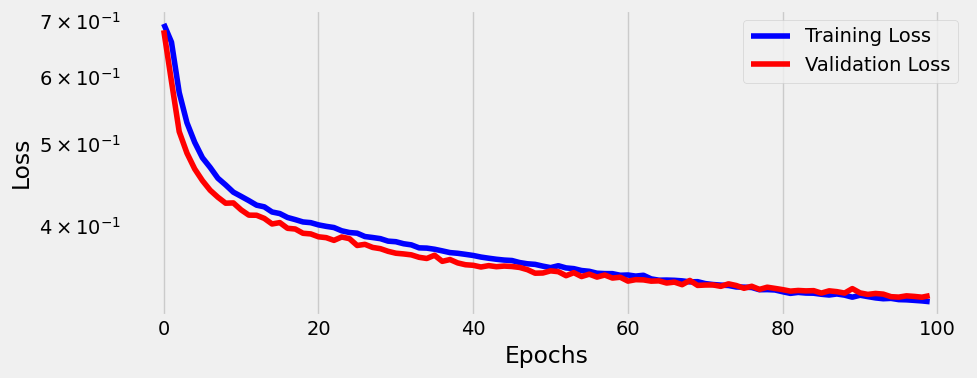

In [ ]:
%%time
n_heads = 5
torch.manual_seed(33)
# Loads the pretrained GloVe embeddings into an embedding layer
extended_embeddings = torch.as_tensor(extended_embeddings).float()
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)
# Creates a Transformer Encoder
layer = EncoderLayer(n_heads=n_heads, d_model=torch_embeddings.embedding_dim, ff_units=ff_units)
encoder = EncoderTransf(layer, n_layers=n_layers, max_len=max_len)

# Uses both layers above to build our model
model = TransfClassifier(torch_embeddings, encoder, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

sbs_transf = StepByStep(model, loss_fn, optimizer)
sbs_transf.set_loaders(train_loader, test_loader)
sbs_transf.train(100)

fig = sbs_transf.plot_losses()

CPU times: user 1h 46min 51s, sys: 14.4 s, total: 1h 47min 6s
Wall time: 1h 47min 50s


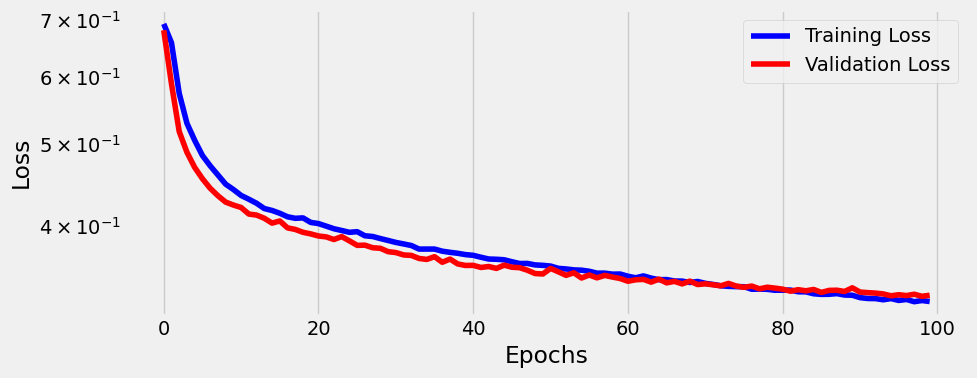

In [ ]:
%%time
n_heads = 5
torch.manual_seed(33)
# Loads the pretrained GloVe embeddings into an embedding layer
extended_embeddings = torch.as_tensor(extended_embeddings).float()
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)
# Creates a Transformer Encoder
layer = EncoderLayer(n_heads=n_heads, d_model=torch_embeddings.embedding_dim, ff_units=ff_units)
encoder = EncoderTransf(layer, n_layers=n_layers, max_len=max_len)

# Uses both layers above to build our model
model = TransfClassifier(torch_embeddings, encoder, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

sbs_transf = StepByStep(model, loss_fn, optimizer)
sbs_transf.set_loaders(train_loader, test_loader)
sbs_transf.train(100)

fig = sbs_transf.plot_losses()

In [ ]:
%%time
n_heads = 5
torch.manual_seed(33)
# Loads the pretrained GloVe embeddings into an embedding layer
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)
# Creates a Transformer Encoder
layer = EncoderLayer(n_heads=n_heads, d_model=torch_embeddings.embedding_dim, ff_units=ff_units)
encoder = EncoderTransf(layer, n_layers=n_layers, max_len=max_len)

# Uses both layers above to build our model
model = TransfClassifier(torch_embeddings, encoder, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

sbs_transf = StepByStep(model, loss_fn, optimizer)
sbs_transf.set_loaders(train_loader, test_loader)
sbs_transf.train(100)

CPU times: user 1h 47min 7s, sys: 21.2 s, total: 1h 47min 29s
Wall time: 1h 48min 27s


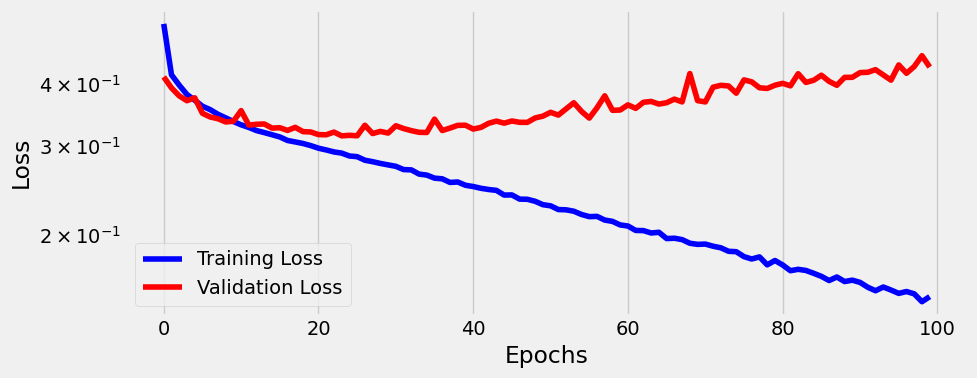

In [ ]:
fig = sbs_transf.plot_losses()

## try to do some evaluation

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.eval()
model.to(device)

TransfClassifier(
  (encoder): EncoderTransf(
    (pe): PositionalEncoding()
    (norm): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (self_attn_heads): MultiHeadedAttention(
          (linear_query): Linear(in_features=50, out_features=50, bias=True)
          (linear_key): Linear(in_features=50, out_features=50, bias=True)
          (linear_value): Linear(in_features=50, out_features=50, bias=True)
          (linear_out): Linear(in_features=50, out_features=50, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ffn): Sequential(
          (0): Linear(in_features=50, out_features=128, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=128, out_features=50, bias=True)
        )
        (sublayers): ModuleList(
          (0-1): 2 x SubLayerWrapper(
            (norm): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
     

In [ ]:
fresh_predict_outcomes=model(next(iter(test_loader))[0].to(device))
fresh_predict_outcomes

tensor([[-2.5827],
        [ 1.1599],
        [-0.9138],
        [-0.6204],
        [-0.4517],
        [ 1.6310],
        [ 0.4394],
        [-2.1012],
        [ 1.3806],
        [-0.7405],
        [-1.2892],
        [ 0.4541],
        [ 2.2810],
        [-2.7926],
        [ 1.4868],
        [ 1.9979],
        [-2.3926],
        [ 1.9380],
        [-2.2333],
        [-0.5925],
        [ 0.9718],
        [-3.1869],
        [-2.1579],
        [-0.3298],
        [ 3.1230],
        [ 0.0843],
        [ 1.1085],
        [ 1.0535],
        [-0.8946],
        [-1.6478],
        [ 0.6025],
        [-2.3282]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
predict_outcome = []
ground_truth = []

for i, (x_batch, y_batch) in enumerate(test_loader):
  x_batch = x_batch.to(device)
  y_batch = y_batch.to(device)
  yhat = model(x_batch)
  predict_outcome.append(yhat)
  ground_truth.append(y_batch)

prediction=nn.Softmax (predict_outcome)
accuracy_score(ground_truth, prediction)
print (accuracy_score(ground_truth, prediction))

NameError: name 'accuracy_score' is not defined

In [ ]:
yhat

tensor([[-2.0470],
        [ 0.8994],
        [ 1.9861],
        [ 2.5739],
        [-2.3769],
        [ 1.4030],
        [ 1.8821],
        [-2.1660],
        [ 0.1957],
        [-3.4547],
        [ 0.4771],
        [-0.9908],
        [ 2.3101],
        [ 2.5536],
        [-0.1196],
        [ 2.1139]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
yhat_prob=torch.sigmoid(yhat)
yhat_prob

tensor([[0.1144],
        [0.7108],
        [0.8793],
        [0.9292],
        [0.0850],
        [0.8027],
        [0.8679],
        [0.1028],
        [0.5488],
        [0.0306],
        [0.6171],
        [0.2708],
        [0.9097],
        [0.9278],
        [0.4701],
        [0.8922]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
yhat2=nn.Softmax(yhat)
yhat2

Softmax(
  dim=tensor([[-2.0470],
          [ 0.8994],
          [ 1.9861],
          [ 2.5739],
          [-2.3769],
          [ 1.4030],
          [ 1.8821],
          [-2.1660],
          [ 0.1957],
          [-3.4547],
          [ 0.4771],
          [-0.9908],
          [ 2.3101],
          [ 2.5536],
          [-0.1196],
          [ 2.1139]], device='cuda:0', grad_fn=<AddmmBackward0>)
)

In [ ]:
yhat_prob2=yhat_prob.cpu().detach().numpy()
yhat_prob2

array([[0.11435232],
       [0.7108277 ],
       [0.8793267 ],
       [0.92916083],
       [0.08495444],
       [0.80266446],
       [0.8678502 ],
       [0.10284457],
       [0.54878163],
       [0.03063045],
       [0.6170519 ],
       [0.27075198],
       [0.9097109 ],
       [0.92781353],
       [0.47013196],
       [0.89224696]], dtype=float32)

In [ ]:
yhat_prob2[yhat_prob2 > 0.5] = 1
yhat_prob2[yhat_prob2 <= 0.5] = 0
yhat_prob2

array([[0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.]], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_batch.cpu().detach().numpy(),yhat_prob2)

0.8125

##  Prod codes - reproduce model resutls

In [ ]:
## load saved data object and create tensor loaders
with open("dataset.pickle", "rb") as f:
   train_ids, train_labels, test_ids, test_labels = pickle.load(f)

train_tensor_dataset = TensorDataset(train_ids, train_labels)
generator = torch.Generator()
train_loader = DataLoader(train_tensor_dataset, batch_size=32, shuffle=True, generator=generator)
test_tensor_dataset = TensorDataset(test_ids, test_labels)
test_loader = DataLoader(test_tensor_dataset, batch_size=32)